In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
def convert_phq8_to_severity(phq8):
    if phq8 >= 0 and phq8 <= 4:
        return 0
    elif phq8 >= 5 and phq8 <= 9:
        return 1
    elif phq8 >= 10 and phq8 <= 14:
        return 2
    elif phq8 >= 15 and phq8 <= 19:
        return 3
    elif phq8 >= 20 and phq8 <= 24:
        return 4

def convert_phq8_to_diagnosis(phq8):
    if phq8 >= 0 and phq8 <= 9:
        return 0
    else:
        return 1

def convert_severity_to_diagnosis(severity):
    if severity >= 0 and severity <= 1:
        return 0
    else:
        return 1

In [3]:
rootdir = "/data/users4/xli/ai-psychiatrist"
filepath = os.path.join(rootdir, "meta_review", "meta_review_test.csv")
pred_df = pd.read_csv(filepath)
pred_df.head(3)

,participant_id,response,severity,explanation
0,316,```xml\n<severity>2</severity>\n<explanation>\...,2,\nBased on the interview transcript and assess...
1,319,```xml\n<severity>2</severity>\n<explanation>\...,2,\nBased on the interview transcript and assess...
2,330,```xml\n<severity>1</severity>\n<explanation>B...,1,Based on the interview transcript and assessme...


In [4]:
dev_split_phq8 = pd.read_csv("/data/users4/xli/ai-psychiatrist/datasets/daic_woz_dataset/dev_split_Depression_AVEC2017.csv")
train_split_phq8 = pd.read_csv("/data/users4/xli/ai-psychiatrist/datasets/daic_woz_dataset/train_split_Depression_AVEC2017.csv")
merged_df = pd.concat([dev_split_phq8, train_split_phq8], ignore_index=True)
gt_df = merged_df.sort_values('Participant_ID').reset_index(drop=True)
gt_df.head(3)

,Participant_ID,PHQ8_Binary,PHQ8_Score,Gender,PHQ8_NoInterest,PHQ8_Depressed,PHQ8_Sleep,PHQ8_Tired,PHQ8_Appetite,PHQ8_Failure,PHQ8_Concentrating,PHQ8_Moving
0,302,0,4,1,1,1,0,1,0,1,0,0
1,303,0,0,0,0,0,0,0,0,0,0,0
2,304,0,6,0,0,1,1,2,2,0,0,0


In [5]:
participant_id_list = pred_df["participant_id"].tolist()
participant_id_list.sort()

gt_severity_list = []
gt_diagnosis_list = []
pred_severity_list = []
pred_diagnosis_list = []

for id in participant_id_list:
    gt_phq = gt_df.loc[gt_df['Participant_ID'] == id, 'PHQ8_Score'].iloc[0]
    gt_severity = convert_phq8_to_severity(gt_phq)
    gt_diagnosis = convert_phq8_to_diagnosis(gt_phq)
    pred_severity = pred_df.loc[pred_df['participant_id'] == id, 'severity'].iloc[0]
    pred_diagnosis = convert_severity_to_diagnosis(pred_severity)
    gt_severity_list.append(gt_severity)
    gt_diagnosis_list.append(gt_diagnosis)
    pred_severity_list.append(pred_severity)
    pred_diagnosis_list.append(pred_diagnosis)

cm_severity = confusion_matrix(gt_severity_list, pred_severity_list, labels=[0, 1, 2, 3, 4])
cm_diagnosis = confusion_matrix(gt_diagnosis_list, pred_diagnosis_list, labels=[0, 1])

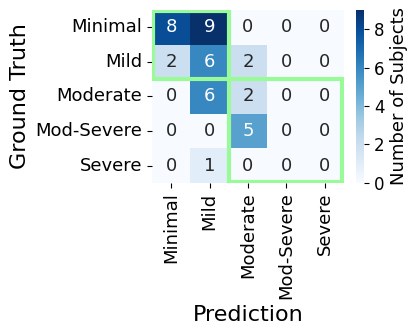

In [6]:
severity_labels = ["Minimal", "Mild", "Moderate", "Mod-Severe", "Severe"]
diagnosis_labels = ["Mild", "Severe"]
label_fontsize = 16
tick_fontsize = 13
colorbar_fontsize = 12

fig, ax = plt.subplots(1, 1, figsize=(4.2, 3.45))

sns.heatmap(cm_severity, annot=True, 
            fmt='d', cmap='Blues', 
            xticklabels=severity_labels, 
            yticklabels=severity_labels,
            ax=ax,
            annot_kws={'size': tick_fontsize})
square = plt.Rectangle((0.015, 0.015), 1.98, 1.98, fill=False, ec="palegreen", linewidth=3, zorder=10)
ax.add_patch(square)
square = plt.Rectangle((2, 2), 2.965, 2.965, fill=False, ec="palegreen", linewidth=3, zorder=10)
ax.add_patch(square)
cbar = ax.collections[0].colorbar
cbar.ax.set_ylabel('Number of Subjects', size=tick_fontsize)
cbar.ax.tick_params(labelsize=colorbar_fontsize)
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
ax.set_xlabel('Prediction', fontsize=label_fontsize)
ax.set_ylabel('Ground Truth', fontsize=label_fontsize)

plt.tight_layout()
# plt.savefig("confusion_matrix_severity.pdf")

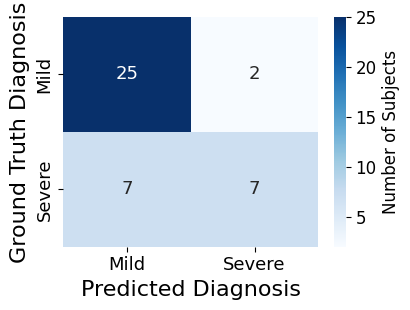

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(4.2, 3.2))

sns.heatmap(cm_diagnosis, annot=True, 
            fmt='d', cmap='Blues', 
            xticklabels=diagnosis_labels, 
            yticklabels=diagnosis_labels,
            ax=ax,
            annot_kws={'size': tick_fontsize})
cbar = ax.collections[0].colorbar
cbar.ax.set_ylabel('Number of Subjects', size=colorbar_fontsize)
cbar.ax.tick_params(labelsize=colorbar_fontsize)
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
ax.set_xlabel('Predicted Diagnosis', fontsize=label_fontsize)
ax.set_ylabel('Ground Truth Diagnosis', fontsize=label_fontsize)

plt.tight_layout()
# plt.savefig("confusion_matrix_diagnosis.pdf")

In [8]:
accuracy = (cm_diagnosis[0,0] + cm_diagnosis[1,1]) / cm_diagnosis.sum()
true_positive_rate = cm_diagnosis[1,1] / (cm_diagnosis[1,0] + cm_diagnosis[1,1])
true_negative_rate = cm_diagnosis[0,0] / (cm_diagnosis[0,0] + cm_diagnosis[0,1])
balanced_accuracy = (true_positive_rate + true_negative_rate) / 2
precision = cm_diagnosis[1,1] / (cm_diagnosis[0,1] + cm_diagnosis[1,1])
recall = cm_diagnosis[1,1] / (cm_diagnosis[1,0] + cm_diagnosis[1,1])
f1 = 2 * (precision * recall) / (precision + recall)
print(accuracy, balanced_accuracy, precision, recall, f1)

0.7804878048780488 0.712962962962963 0.7777777777777778 0.5 0.6086956521739131


In [9]:
expert_phq8 = [4,4,4,14,6,19,19,4,0,0]
gt_phq8 = [7,5,15,23,20,19,12,10,2,3]

gt10_severity_list = []
gt10_diagnosis_list = []
expert_severity_list = []
expert_diagnosis_list = []

for i in range(len(expert_phq8)):
    gt_phq = gt_phq8[i]
    gt_severity = convert_phq8_to_severity(gt_phq)
    gt_diagnosis = convert_phq8_to_diagnosis(gt_phq)
    expert_phq = expert_phq8[i]
    expert_severity = convert_phq8_to_severity(expert_phq)
    expert_diagnosis = convert_severity_to_diagnosis(expert_severity)
    gt10_severity_list.append(gt_severity)
    gt10_diagnosis_list.append(gt_diagnosis)
    expert_severity_list.append(expert_severity)
    expert_diagnosis_list.append(expert_diagnosis)

cm_severity_expert = confusion_matrix(gt10_severity_list, expert_severity_list, labels=[0, 1, 2, 3, 4])
cm_diagnosis_expert = confusion_matrix(gt10_diagnosis_list, expert_diagnosis_list, labels=[0, 1])

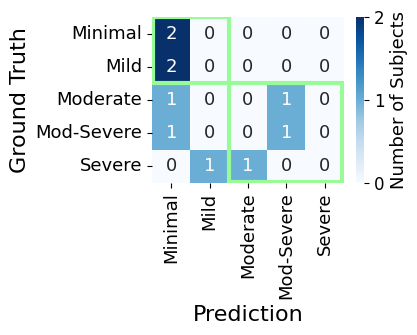

In [10]:
severity_labels = ["Minimal", "Mild", "Moderate", "Mod-Severe", "Severe"]
diagnosis_labels = ["Mild", "Severe"]
label_fontsize = 16
tick_fontsize = 13
colorbar_fontsize = 12

fig, ax = plt.subplots(1, 1, figsize=(4.2, 3.45))

sns.heatmap(cm_severity_expert, annot=True, 
            fmt='d', cmap='Blues', 
            xticklabels=severity_labels, 
            yticklabels=severity_labels,
            ax=ax,
            annot_kws={'size': tick_fontsize})
square = plt.Rectangle((0.015, 0.015), 1.98, 1.98, fill=False, ec="palegreen", linewidth=3, zorder=10)
ax.add_patch(square)
square = plt.Rectangle((2, 2), 2.965, 2.965, fill=False, ec="palegreen", linewidth=3, zorder=10)
ax.add_patch(square)
cbar = ax.collections[0].colorbar
cbar.ax.set_ylabel('Number of Subjects', size=tick_fontsize)
cbar.ax.tick_params(labelsize=colorbar_fontsize)
cbar.ax.set_yticks([0,1,2], [0,1,2])
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
ax.set_xlabel('Prediction', fontsize=label_fontsize)
ax.set_ylabel('Ground Truth', fontsize=label_fontsize)

plt.tight_layout()
# plt.savefig("confusion_matrix_severity_10subjects.pdf")

In [11]:
accuracy = (cm_diagnosis_expert[0,0] + cm_diagnosis_expert[1,1]) / cm_diagnosis_expert.sum()
true_positive_rate = cm_diagnosis_expert[1,1] / (cm_diagnosis_expert[1,0] + cm_diagnosis_expert[1,1])
true_negative_rate = cm_diagnosis_expert[0,0] / (cm_diagnosis_expert[0,0] + cm_diagnosis_expert[0,1])
balanced_accuracy = (true_positive_rate + true_negative_rate) / 2
precision = cm_diagnosis_expert[1,1] / (cm_diagnosis_expert[0,1] + cm_diagnosis_expert[1,1])
recall = cm_diagnosis_expert[1,1] / (cm_diagnosis_expert[1,0] + cm_diagnosis_expert[1,1])
f1 = 2 * (precision * recall) / (precision + recall)
print(accuracy, balanced_accuracy, precision, recall, f1)

0.7 0.75 1.0 0.5 0.6666666666666666


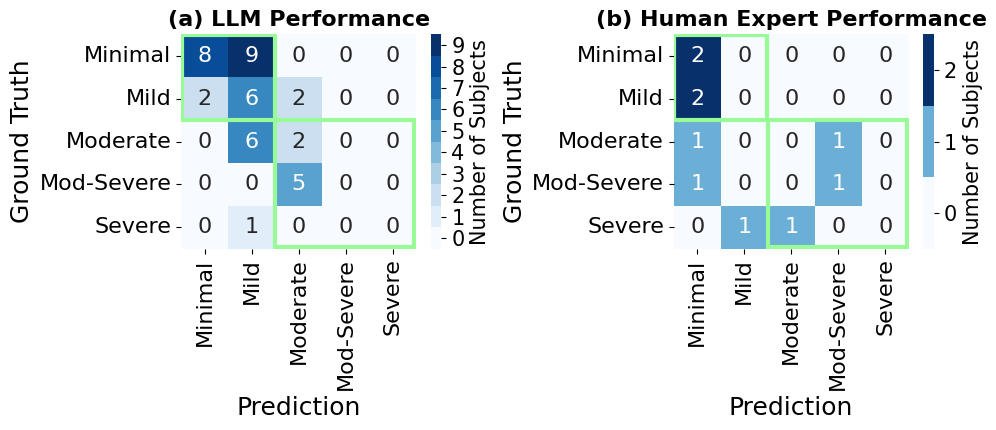

In [12]:
cm_list = [cm_severity, cm_severity_expert]
title_list = ["(a) LLM Performance", "(b) Human Expert Performance"]
severity_labels = ["Minimal", "Mild", "Moderate", "Mod-Severe", "Severe"]
diagnosis_labels = ["Mild", "Severe"]
title_fontsize = 16
label_fontsize = 18
tick_fontsize = 16
colorbar_fontsize = 15

fig, axes = plt.subplots(1, 2, figsize=(10, 4.4))

for i, ax in enumerate(axes):
    cm = cm_list[i]
    n_bins = np.max(cm)+1
    cmap = plt.get_cmap('Blues', n_bins)
    sns.heatmap(cm, annot=True, 
                fmt='d', cmap=cmap, 
                xticklabels=severity_labels, 
                yticklabels=severity_labels,
                ax=ax,
                annot_kws={'size': tick_fontsize})
    square = plt.Rectangle((0.015, 0.015), 1.98, 1.98, fill=False, ec="palegreen", linewidth=3, zorder=10)
    ax.add_patch(square)
    square = plt.Rectangle((2, 2), 2.965, 2.965, fill=False, ec="palegreen", linewidth=3, zorder=10)
    ax.add_patch(square)
    cbar = ax.collections[0].colorbar
    cbar.set_ticks(np.arange((n_bins-1)/(2*n_bins), n_bins-1, (n_bins-1)/n_bins))
    cbar.set_ticklabels(range(n_bins))
    cbar.ax.set_ylabel('Number of Subjects', size=colorbar_fontsize)
    cbar.ax.tick_params(labelsize=colorbar_fontsize)
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
    ax.set_xlabel('Prediction', fontsize=label_fontsize)
    ax.set_ylabel('Ground Truth', fontsize=label_fontsize)
    ax.set_title(title_list[i], fontsize=title_fontsize, fontweight='bold')

plt.tight_layout()
# plt.savefig("confusion_matrix_severity.pdf")